# Distributed Coordinate Descent for L1-regularized Logistic Regression

In [1]:
# Import des packages

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.random import multivariate_normal
from numpy.random import randn
from scipy.linalg.special_matrices import toeplitz
import time

In [2]:
%load_ext autoreload
%autoreload 2
import LogisticLasso

## Simulation des données

In [3]:
# Sélection des paramètres

n = 100000 # Nombre de données
p = 1000 # Nombre de variables
p_nul = 600 # Nombre de variables nulles
inclinaison = 50 # Rapidité de décroissance des coefficients des variables
corr = 0.25 # Correlation des variables

lmbd = 20. # Penalisation L1

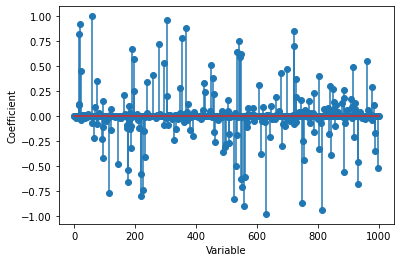

In [4]:
# Génération des coefficients

def simu_coef(p, p_nul, inclinaison):
    index = np.arange(p)
    coefs = ((-1)**index) * np.exp(-index/inclinaison)
    coefs[-p_nul:] = 0
    return coefs
    
coefs = simu_coef(p, p_nul, inclinaison)

# Simulation des données

def simu_data(n, p, coefs, corr):
    cov = toeplitz(corr ** np.arange(0, p))
    X = multivariate_normal(np.zeros(p), cov, size=n)
    y = np.sign(X.dot(coefs) + randn(n))
    return X, y

X, y = simu_data(n, p, coefs, corr)

permu = np.random.permutation(p)
coefs = coefs[permu]
X = X[:,permu]
X = np.ascontiguousarray(X)

plt.stem(coefs)
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

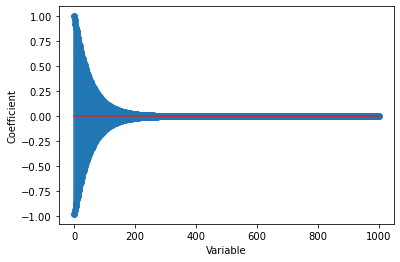

In [5]:
order = np.argsort(-np.abs(coefs))
plt.stem(coefs[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

## Coordinate Descent non distribuée

In [6]:
model_cd = LogisticLasso.LogisticLasso(solver="cd", lmbd=lmbd, max_iter=2000, tol=1e-6)

In [7]:
start = time.perf_counter()
model_cd.fit(X, y)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 68.92 min


In [8]:
print("Nombre d'itérations :", len(model_cd.objectif_list_))

Nombre d'itérations : 757


In [9]:
print("Temps par itération :", round(executing_time/len(model_cd.objectif_list_),2), "s")

Temps par itération : 5.46 s


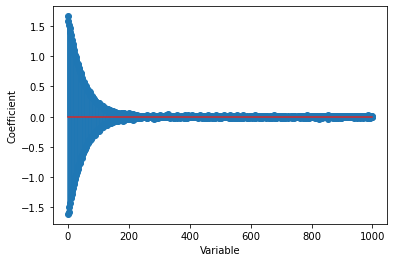

In [10]:
plt.stem(model_cd.coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [11]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(model_cd.coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 37.24834403935499


In [12]:
print("Accuracy : ", np.sum(model_cd.predict(X)==y)/n)

Accuracy :  0.9233


## Coordinate Descent non distribuée avec numba

In [13]:
model_cd_numba = LogisticLasso.LogisticLasso(solver="cd_numba", lmbd=lmbd, max_iter=2000, tol=1e-6)

In [14]:
start = time.perf_counter()
model_cd_numba.fit(X, y)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 39.46 min


In [15]:
print("Nombre d'itérations :", len(model_cd_numba.objectif_list_))

Nombre d'itérations : 757


In [16]:
print("Temps par itération :", round(executing_time/len(model_cd_numba.objectif_list_),2), "s")

Temps par itération : 3.13 s


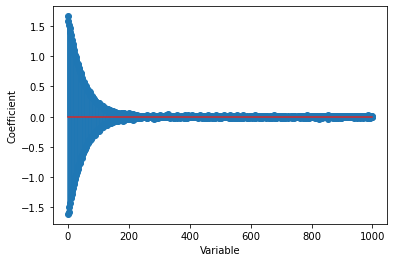

In [17]:
plt.stem(model_cd_numba.coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [18]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(model_cd_numba.coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 37.248344039355


In [19]:
print("Accuracy : ", np.sum(model_cd_numba.predict(X)==y)/n)

Accuracy :  0.9233


## dGLMNET Séquentiel

In [20]:
%load_ext autoreload
%autoreload 2
import dGLMNET_sequential

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### M=4

In [21]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_sequential.dGLMNET_solver(X, y, lmbd, 4, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 2.4 min


In [22]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 10


In [23]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 14.42 s


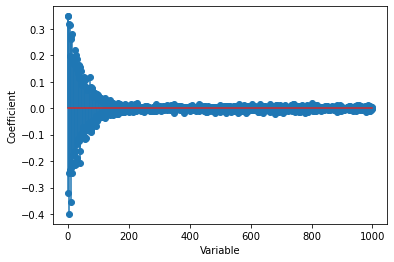

In [24]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [25]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 38.74419893380815


In [26]:
print("Accuracy : ", np.sum(dGLMNET_sequential.predict(X, coef_)==y)/n)

Accuracy :  0.89236


#### M=10

In [27]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_sequential.dGLMNET_solver(X, y, lmbd, 10, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.95 min


In [28]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 8


In [29]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 7.1 s


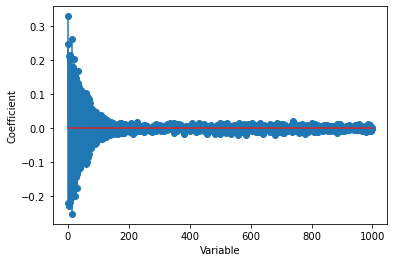

In [30]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [31]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 40.89160495380922


In [32]:
print("Accuracy : ", np.sum(dGLMNET_sequential.predict(X, coef_)==y)/n)

Accuracy :  0.89634


#### M=40

In [33]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_sequential.dGLMNET_solver(X, y, lmbd, 40, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.42 min


In [34]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 8


In [35]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 3.13 s


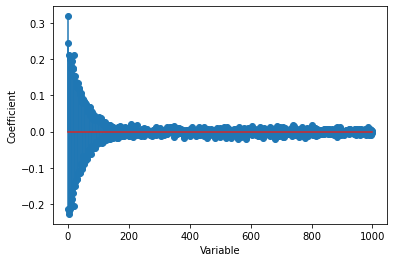

In [36]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [37]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 41.682281057871876


In [38]:
print("Accuracy : ", np.sum(dGLMNET_sequential.predict(X, coef_)==y)/n)

Accuracy :  0.8967


#### M=100

In [39]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_sequential.dGLMNET_solver(X, y, lmbd, 100, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.28 min


In [40]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 7


In [41]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 2.41 s


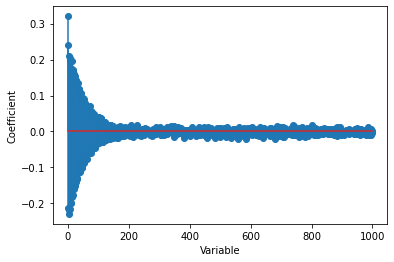

In [42]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [43]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 41.7924998894392


In [44]:
print("Accuracy : ", np.sum(dGLMNET_sequential.predict(X, coef_)==y)/n)

Accuracy :  0.89849


## dGLMNET multiprocessing avec ProcessPool

In [45]:
%load_ext autoreload
%autoreload 2
import dGLMNET_multiprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### M=4

In [46]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_multiprocessing.dGLMNET_solver(X, y, lmbd, 4, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 2.99 min


In [47]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 10


In [48]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 17.92 s


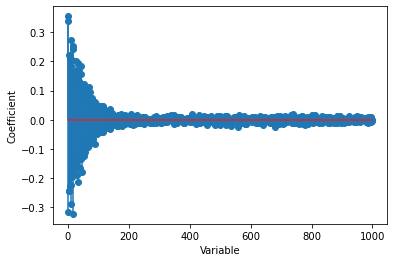

In [49]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [50]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 38.918373389489346


In [51]:
print("Accuracy : ", np.sum(dGLMNET_multiprocessing.predict(X, coef_)==y)/n)

Accuracy :  0.8916


#### M=10

In [52]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_multiprocessing.dGLMNET_solver(X, y, lmbd, 10, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 1.26 min


In [53]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 9


In [54]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 8.4 s


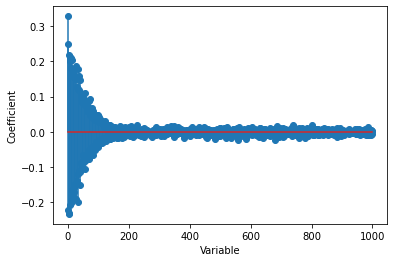

In [55]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [56]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 40.949943009637565


In [57]:
print("Accuracy : ", np.sum(dGLMNET_multiprocessing.predict(X, coef_)==y)/n)

Accuracy :  0.89552


#### M=40

In [58]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_multiprocessing.dGLMNET_solver(X, y, lmbd, 40, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.59 min


In [59]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 7


In [60]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 5.09 s


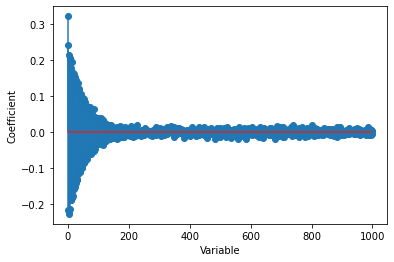

In [61]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [62]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 41.635862249799274


In [63]:
print("Accuracy : ", np.sum(dGLMNET_multiprocessing.predict(X, coef_)==y)/n)

Accuracy :  0.89971


#### M=100

In [64]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_multiprocessing.dGLMNET_solver(X, y, lmbd, 100, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.57 min


In [65]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 7


In [66]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 4.85 s


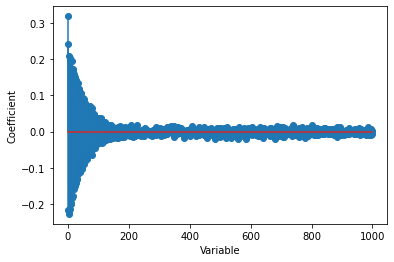

In [67]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [68]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 41.78347421183027


In [69]:
print("Accuracy : ", np.sum(dGLMNET_multiprocessing.predict(X, coef_)==y)/n)

Accuracy :  0.8988


## dGLMNET multithread avec ThreadPool

In [70]:
%load_ext autoreload
%autoreload 2
import dGLMNET_multithread

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### M=4

In [71]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_multithread.dGLMNET_solver(X, y, lmbd, 4, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 2.61 min


In [72]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 11


In [73]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 14.21 s


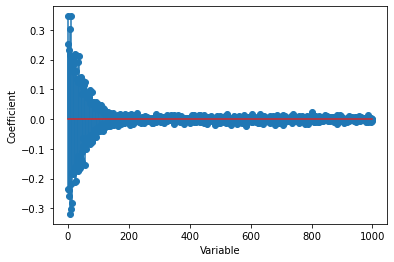

In [74]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [75]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 38.9532397748534


In [76]:
print("Accuracy : ", np.sum(dGLMNET_multithread.predict(X, coef_)==y)/n)

Accuracy :  0.89006


#### M=10

In [77]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_multithread.dGLMNET_solver(X, y, lmbd, 10, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 1.0 min


In [78]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 9


In [79]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 6.68 s


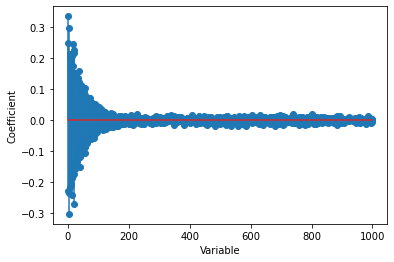

In [80]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [81]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 40.70092005515655


In [82]:
print("Accuracy : ", np.sum(dGLMNET_multithread.predict(X, coef_)==y)/n)

Accuracy :  0.89313


#### M=40

In [83]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_multithread.dGLMNET_solver(X, y, lmbd, 40, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.41 min


In [84]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 8


In [85]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 3.07 s


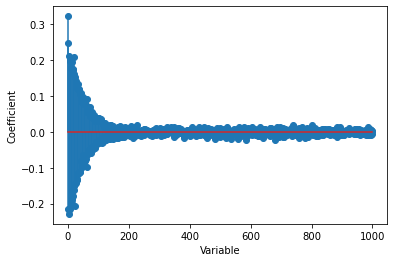

In [86]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [87]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 41.62734071457537


In [88]:
print("Accuracy : ", np.sum(dGLMNET_multithread.predict(X, coef_)==y)/n)

Accuracy :  0.89627


#### M=100

In [89]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_multithread.dGLMNET_solver(X, y, lmbd, 100, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.87 min


In [90]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 6


In [91]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 8.67 s


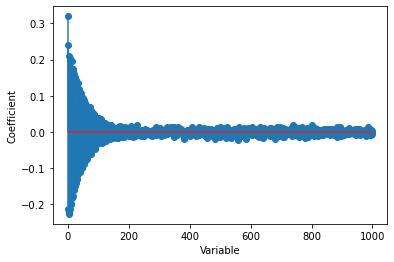

In [92]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [93]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 41.82599677884791


In [94]:
print("Accuracy : ", np.sum(dGLMNET_multithread.predict(X, coef_)==y)/n)

Accuracy :  0.89857


## dGLMNET cython

Avant d'exécuter la partie suivante, il faut compiler dGLMNET_cython par exemple avec "python setup.py build_ext --inplace" en ligne de commande.

In [95]:
%load_ext autoreload
%autoreload 2
import dGLMNET_cython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### M=4

In [96]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_cython.dGLMNET_solver(X, y, lmbd, 4, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 2.67 min


In [97]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 13


In [98]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 12.32 s


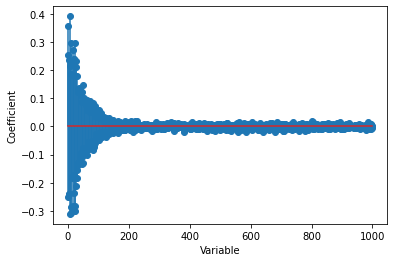

In [99]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [100]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 38.43393213261879


In [101]:
print("Accuracy : ", np.sum(dGLMNET_cython.predict(X, coef_)==y)/n)

Accuracy :  0.88692


#### M=10

In [102]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_cython.dGLMNET_solver(X, y, lmbd, 10, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.97 min


In [103]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 11


In [104]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 5.28 s


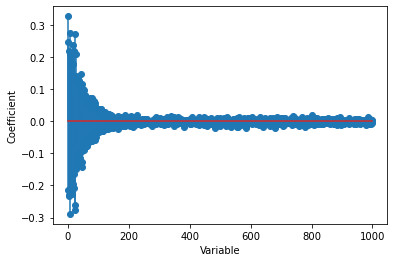

In [105]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [106]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 40.24472023038906


In [107]:
print("Accuracy : ", np.sum(dGLMNET_cython.predict(X, coef_)==y)/n)

Accuracy :  0.89105


#### M=40

In [108]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_cython.dGLMNET_solver(X, y, lmbd, 40, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.17 min


In [109]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 9


In [110]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 1.1 s


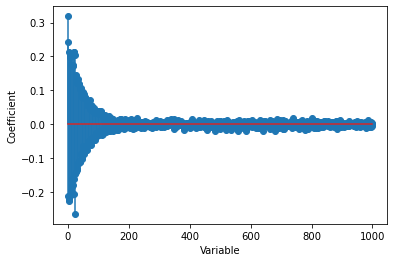

In [111]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [112]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 41.34949609475416


In [113]:
print("Accuracy : ", np.sum(dGLMNET_cython.predict(X, coef_)==y)/n)

Accuracy :  0.89446


#### M=100

In [114]:
start = time.perf_counter()
coef_, objectif_list_ = dGLMNET_cython.dGLMNET_solver(X, y, lmbd, 100, 1000)
end = time.perf_counter()
executing_time = end - start
print("Temps d'exécution :", round(executing_time/60,2), "min")

Temps d'exécution : 0.08 min


In [115]:
print("Nombre d'itérations :", len(objectif_list_))

Nombre d'itérations : 8


In [116]:
print("Temps par itération :", round(executing_time/len(objectif_list_),2), "s")

Temps par itération : 0.59 s


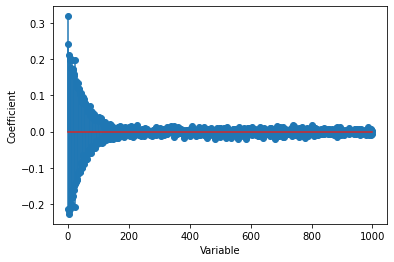

In [117]:
plt.stem(coef_[order])
plt.xlabel("Variable")
plt.ylabel("Coefficient")
plt.show()

In [118]:
print("Ecart entre les coefficients réels et estimés :",
      np.sum(np.abs(coef_ - coefs)))

Ecart entre les coefficients réels et estimés : 41.69411832867938


In [119]:
print("Accuracy : ", np.sum(dGLMNET_cython.predict(X, coef_)==y)/n)

Accuracy :  0.89737
